In [1]:
import geopandas as gpd
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs

In [2]:
cities = [
    "Albuquerque",
    "Atlanta",
    "Baltimore",
    "Boston", 
    "Boulder",
    "Chicago", 
    "Detroit",
    "Durham", 
    "Houston",
    "Kansas",
    "Las Vegas",
    "Los Angeles",
    "Miami",
    "Nashville",
    "New Orleans",
    "NYC",
    "Oklahoma",
    "San Francisco", 
    "Seattle", 
    "Washington DC"]

In [10]:
for city in cities:
    # This code loads the census tract shapefile for Durham County
    trav = gpd.read_file(f'../data/shapefiles/{city}/pm_trav.shp')

    # Convert to the same coordinate system as the desired NLCD data
    # it should always be EPSG:3857 (because that's in meters)
    trav = trav.to_crs(epsg=3857)
    bounds = trav.total_bounds

    # Add a buffer to the bounds (in meters) to make sure that we have sufficient space around the traversal path.
    # I recommend a buffer of 1000 meters, but to be conservative, you could make it 2000 meters, too. 
    print('before', bounds)
    bounds = [bounds[0]-1000, bounds[1]-1000, bounds[2]+1000, bounds[3]+1000]
    print('after', bounds)

    !gdalwarp ../Annual_NLCD_LndCov_2023_CU_C1V0.tif -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -t_srs EPSG:3857 -tr 10 10 -tap -of GTiff '../data/land/{city}_nlcd.tif'

before [-11887092.08089043   4161335.42377587 -11853764.69513929
   4193532.90677987]
after [np.float64(-11888092.08089043), np.float64(4160335.423775873), np.float64(-11852764.695139285), np.float64(4194532.906779872)]
Copying color table from ../Annual_NLCD_LndCov_2023_CU_C1V0.tif to new file.
Creating output file that is 3534P x 3421L.
Using internal nodata values (e.g. 250) for image ../Annual_NLCD_LndCov_2023_CU_C1V0.tif.
Copying nodata values from source ../Annual_NLCD_LndCov_2023_CU_C1V0.tif to destination ../data/land/Albuquerque_nlcd.tif.
Processing ../Annual_NLCD_LndCov_2023_CU_C1V0.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
before [-9407641.70746194  3988090.3887931  -9385877.07721949  4012320.63509133]
after [np.float64(-9408641.70746194), np.float64(3987090.388793101), np.float64(-9384877.077219494), np.float64(4013320.6350913304)]
Copying color table from ../Annual_NLCD_LndCov_2023_CU_C1V0.tif to new file.
Creating output file that is 2378P x

# Visualize the NLCD data

In [3]:
# Let's create a colormap with 15 colors, to match the 15 classes in the NLCD dataset.
custom_colors = [
    "royalblue",
    "mistyrose",
    "salmon",
    "red",
    "darkred",
    "tan",
    "lawngreen",
    "darkgreen",
    "yellowgreen",
    "goldenrod",
    "lemonchiffon",
    "yellow",
    "violet",
    "lightblue",
    "cyan"
]
cmap = colors.ListedColormap(custom_colors)

58.15179621456542
89.89629915485445
59.315466202207666
85.16783987820573
56.01066611341946
75.30927220789665
76.00545346959011
58.90231869267375
77.40392984677824
86.59301285103784
47.93064733715258
78.94053963830027
90.79737242664807
78.23776224819103
54.88740807294267
83.35347492938729
55.23528609803482
57.36013015062691
43.30917454771237
89.32841217766928


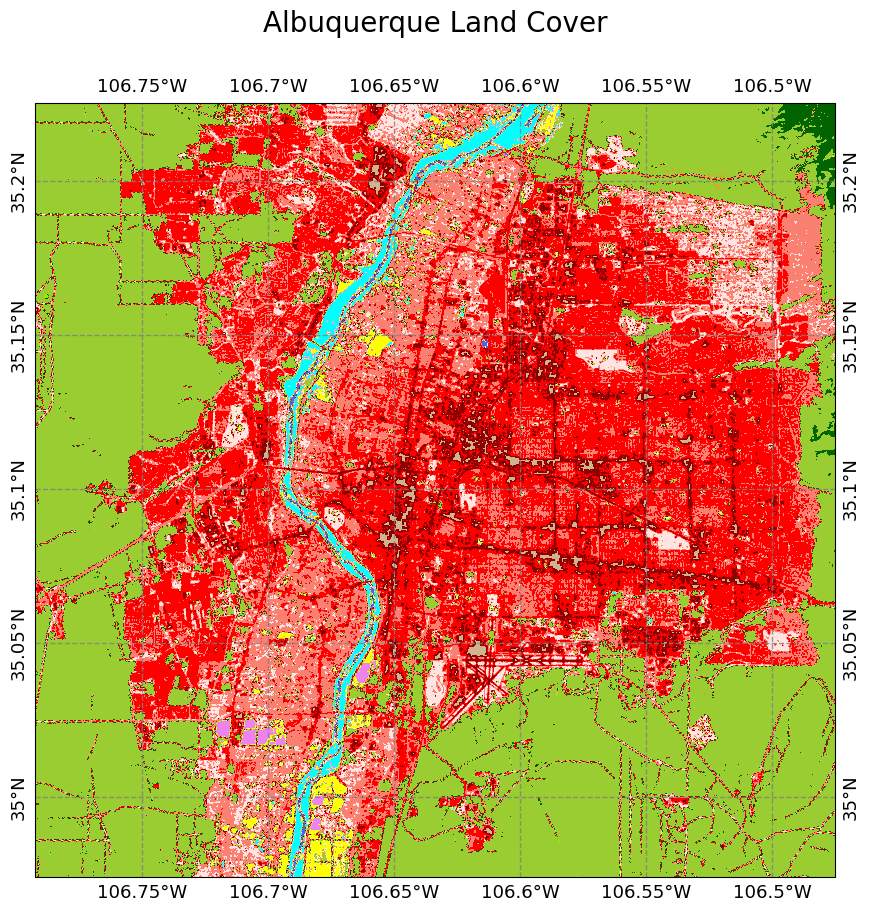

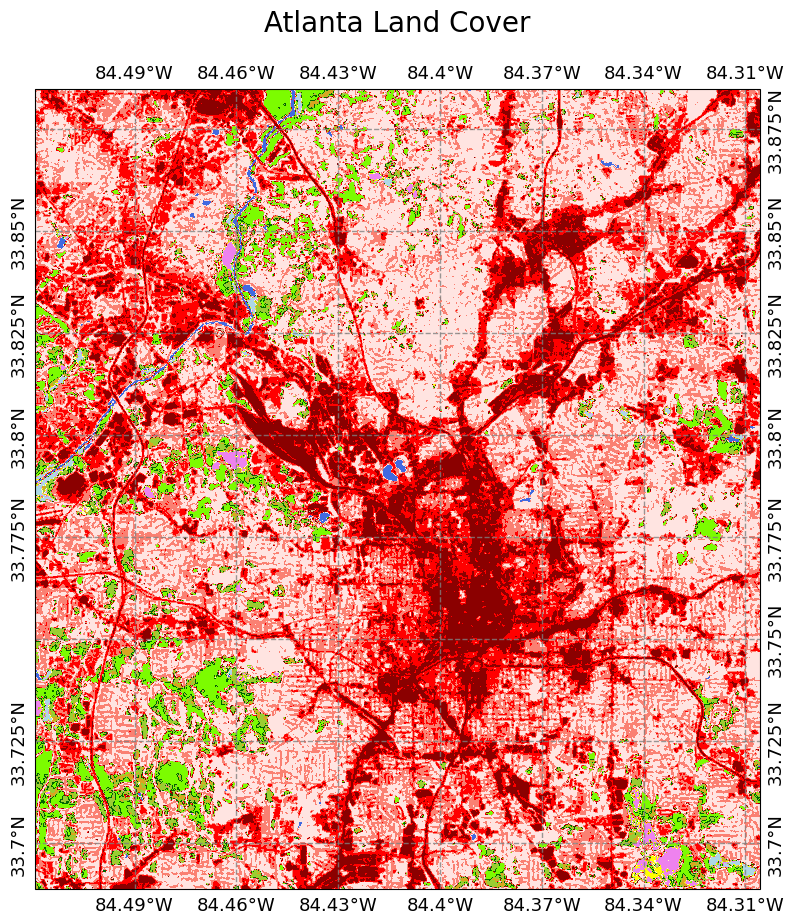

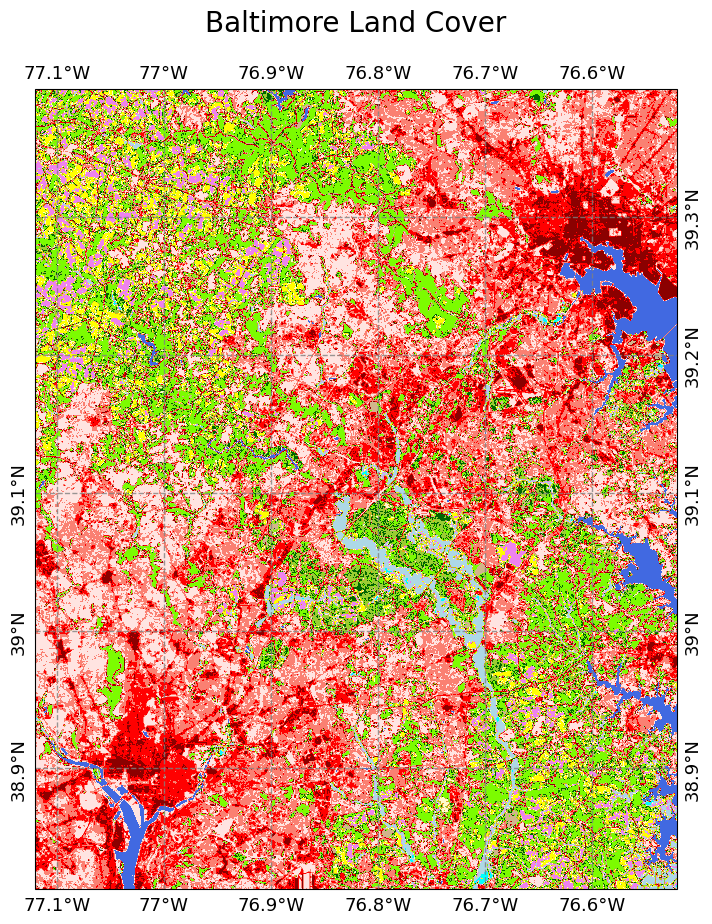

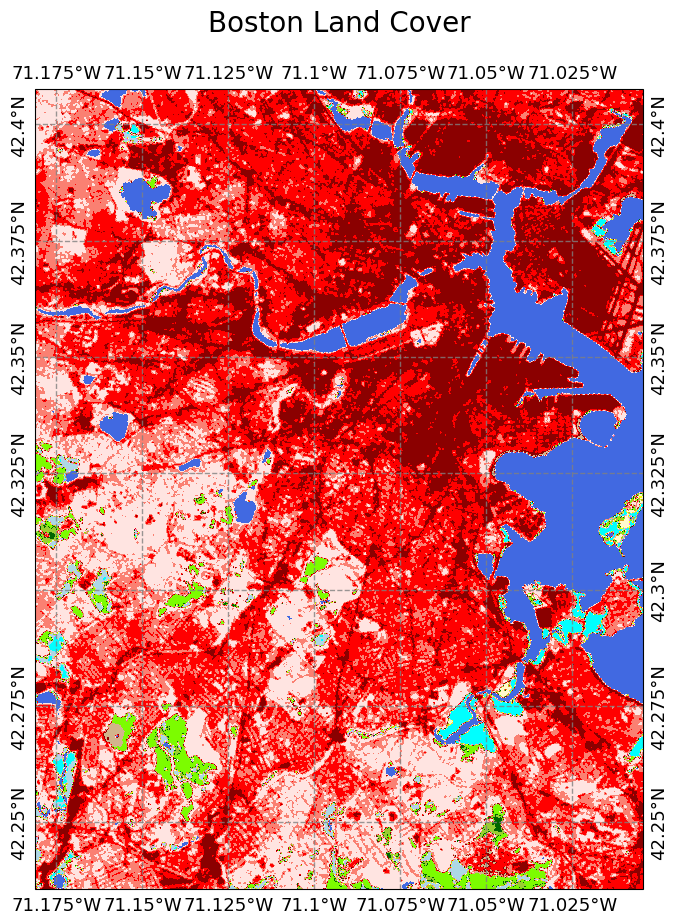

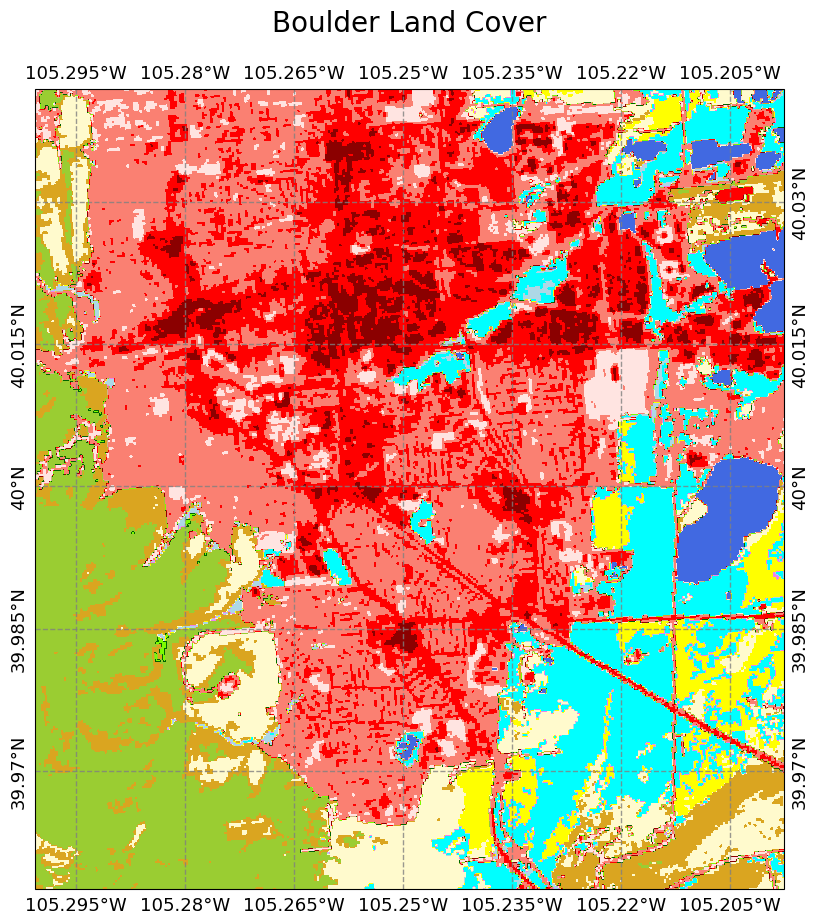

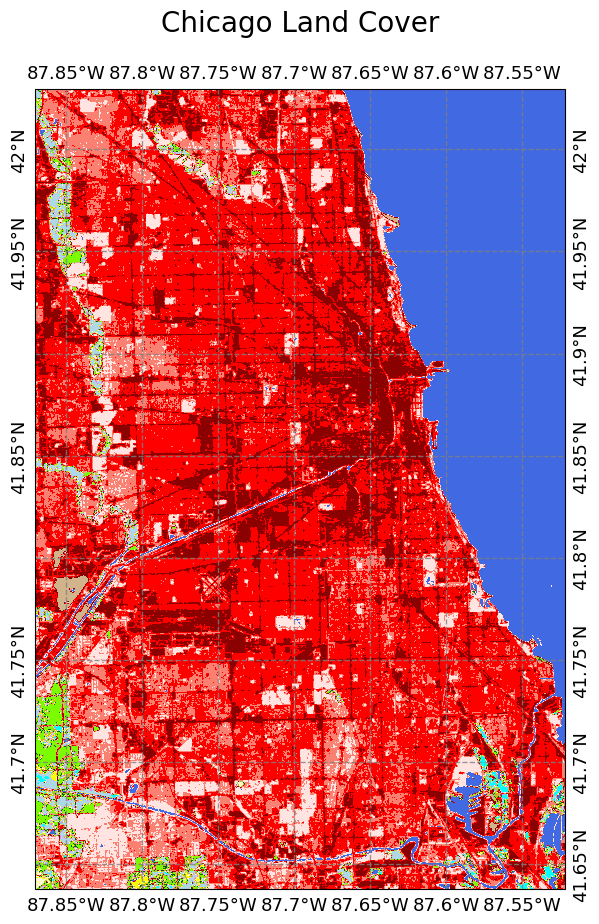

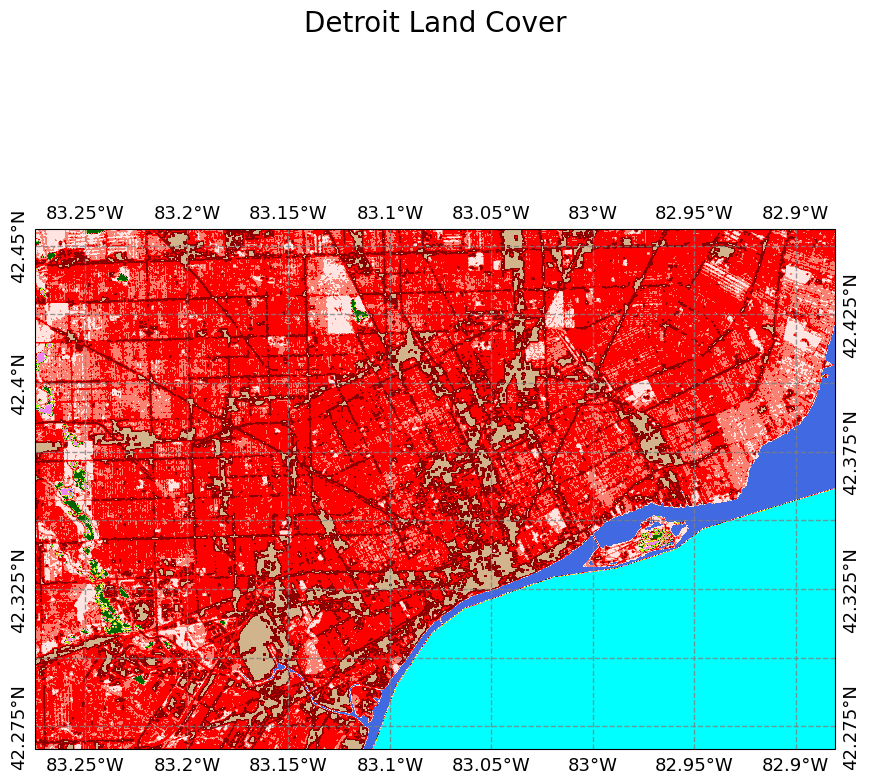

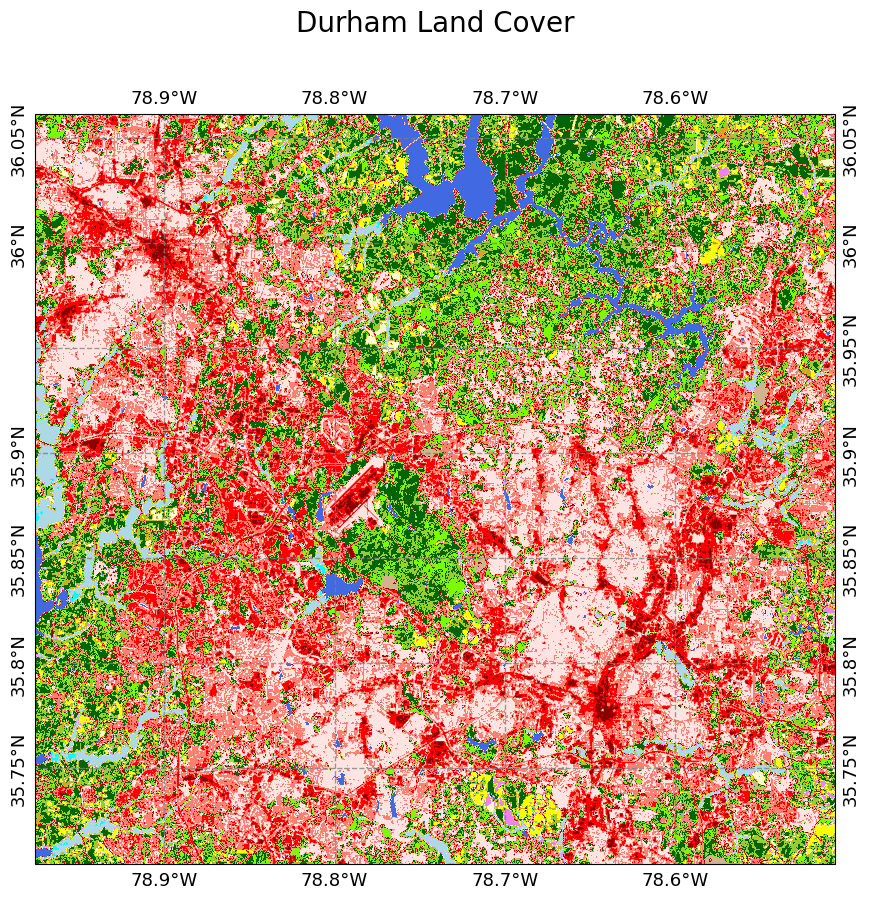

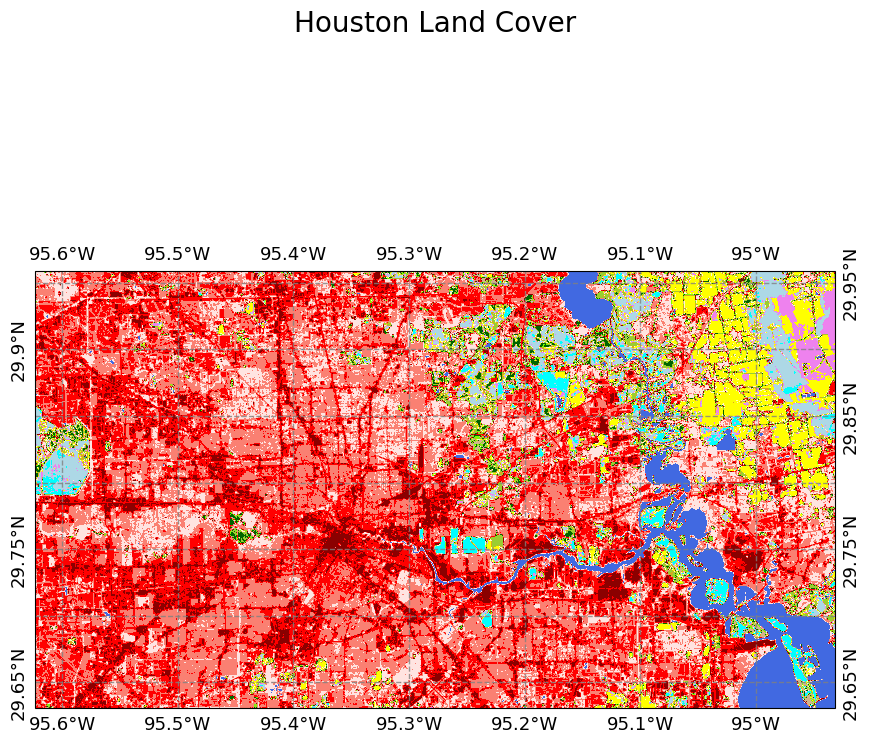

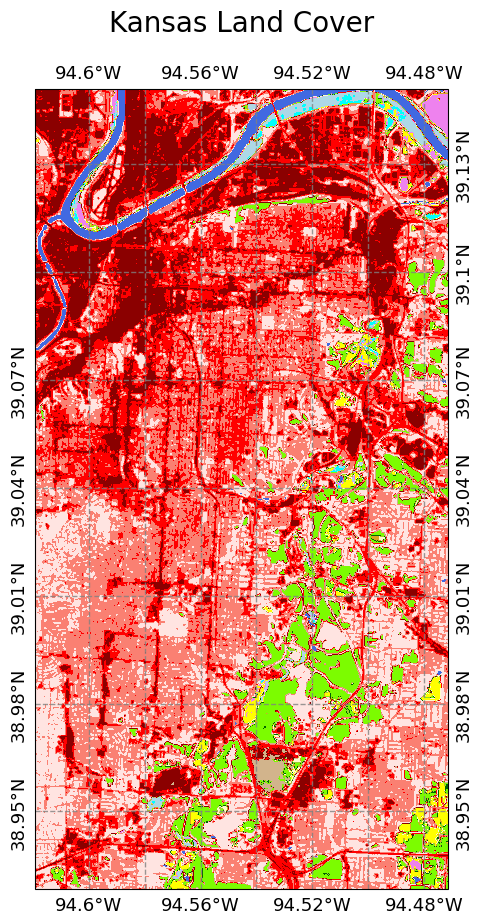

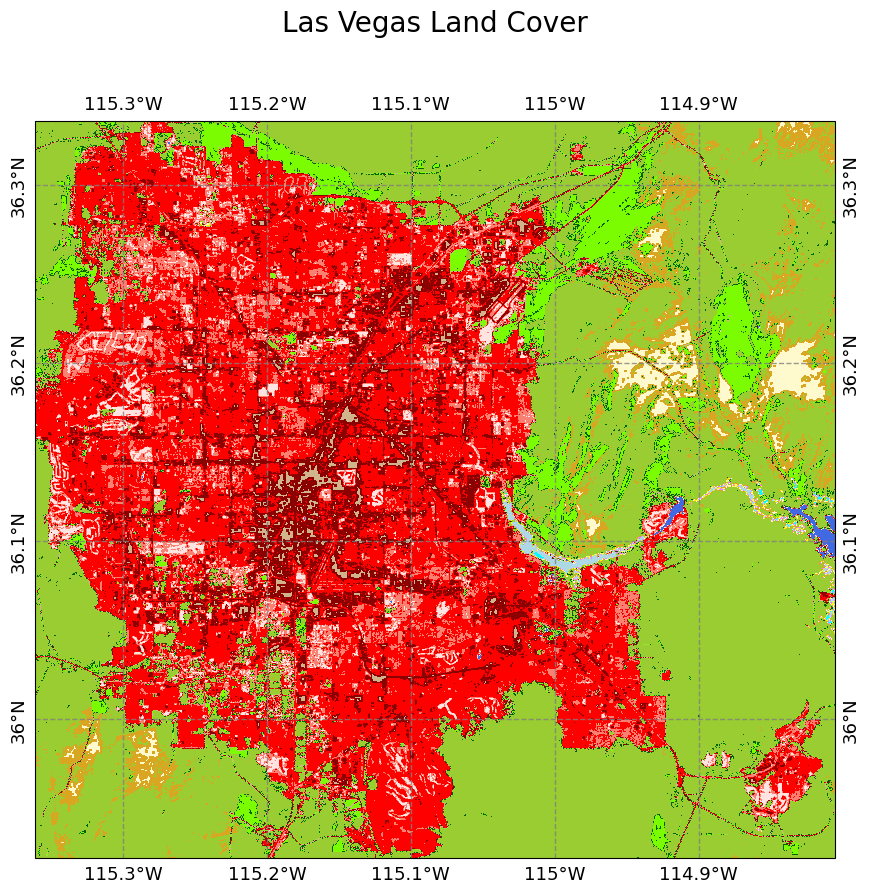

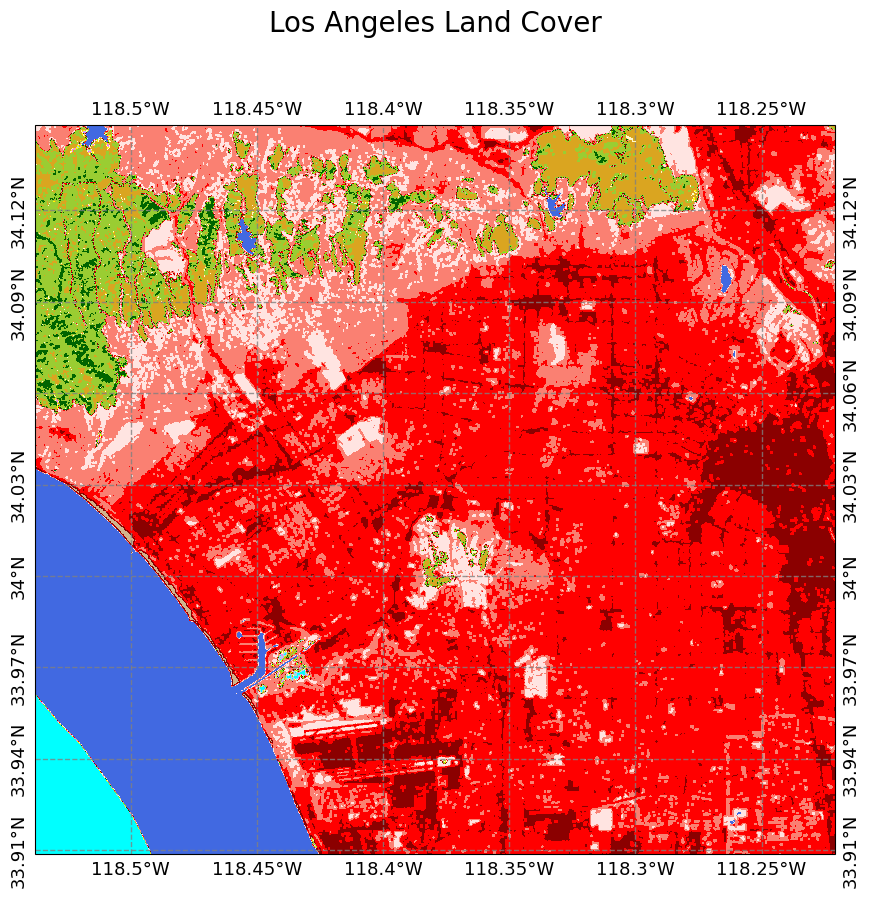

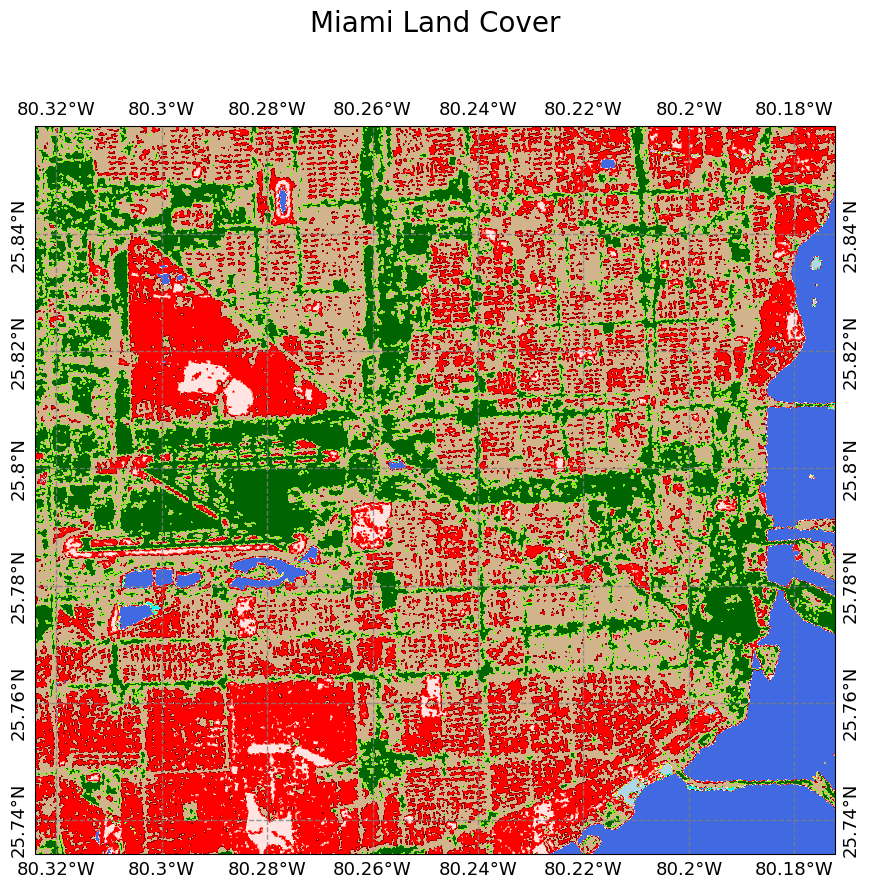

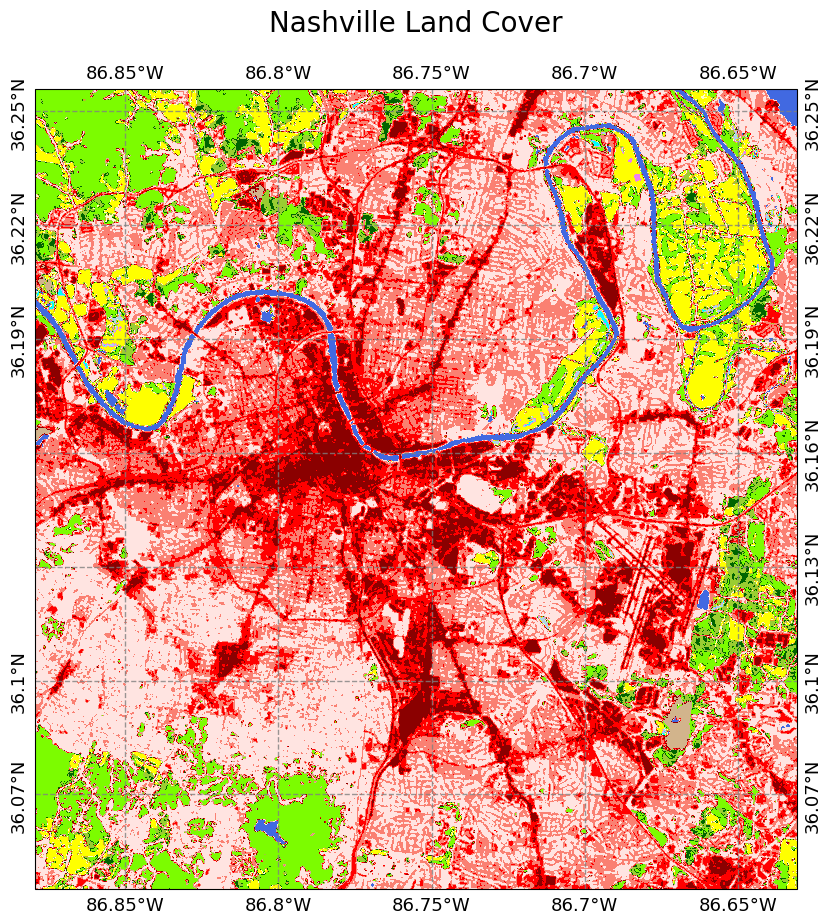

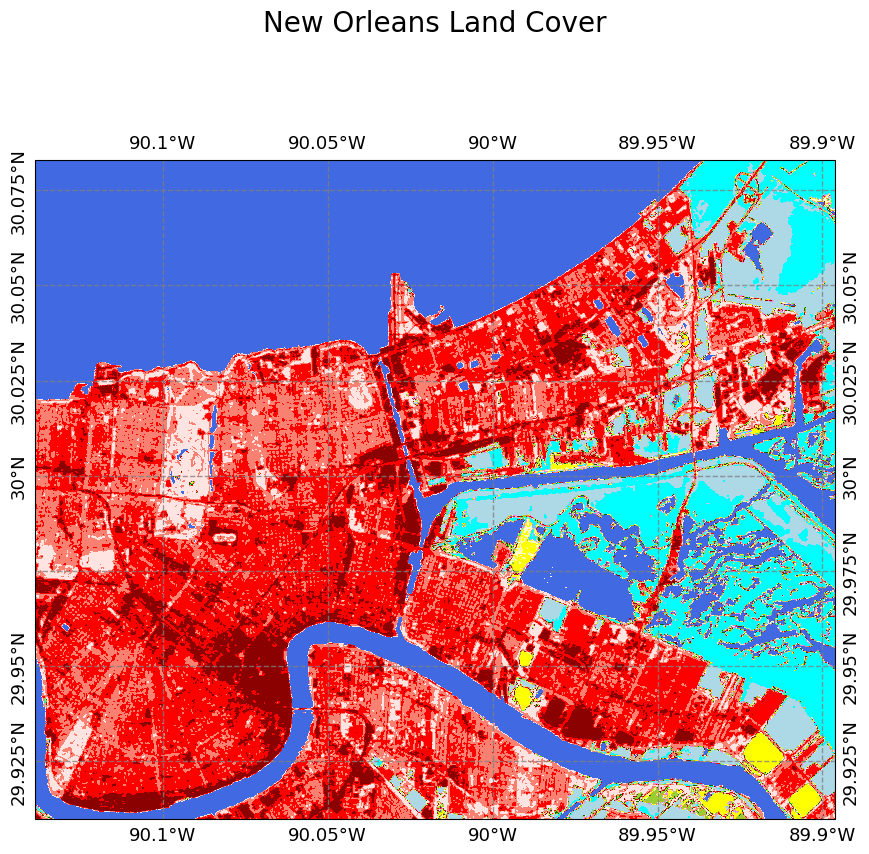

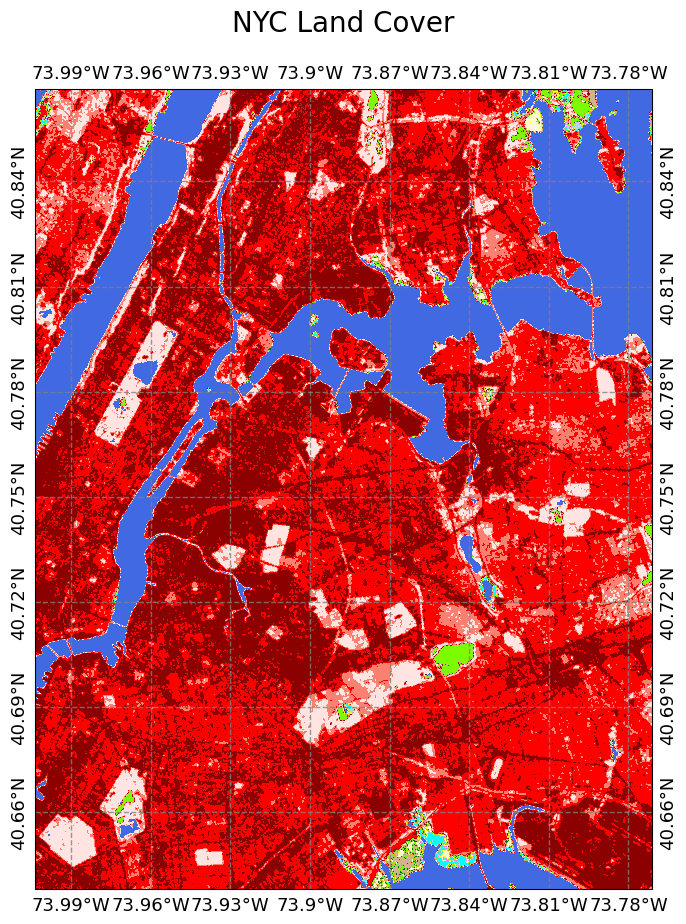

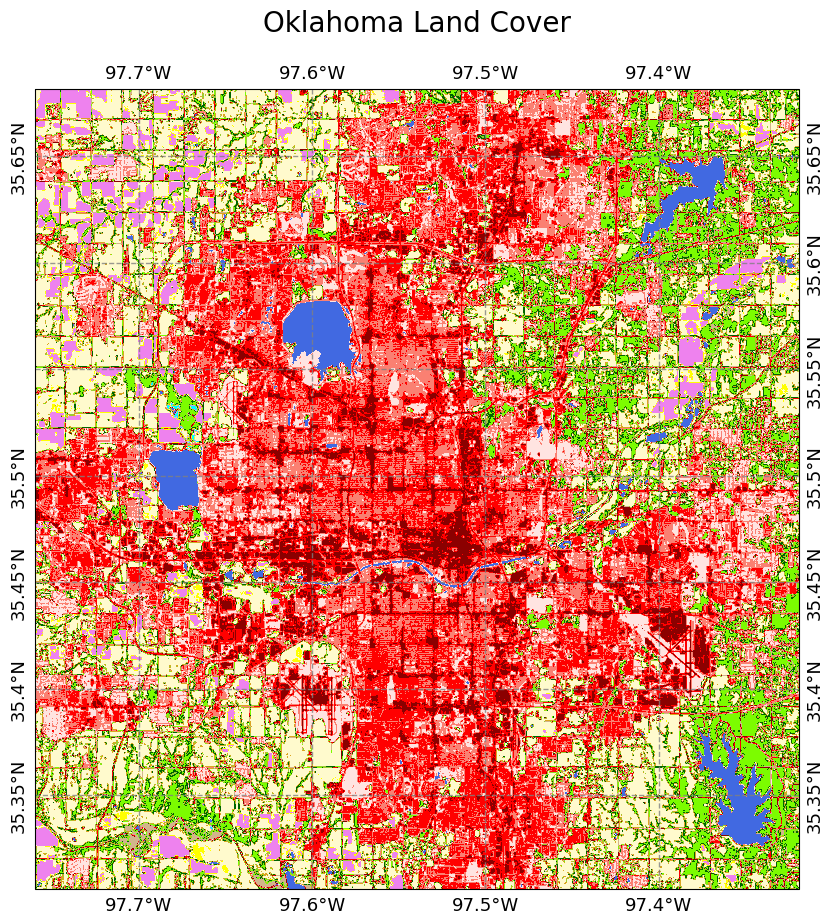

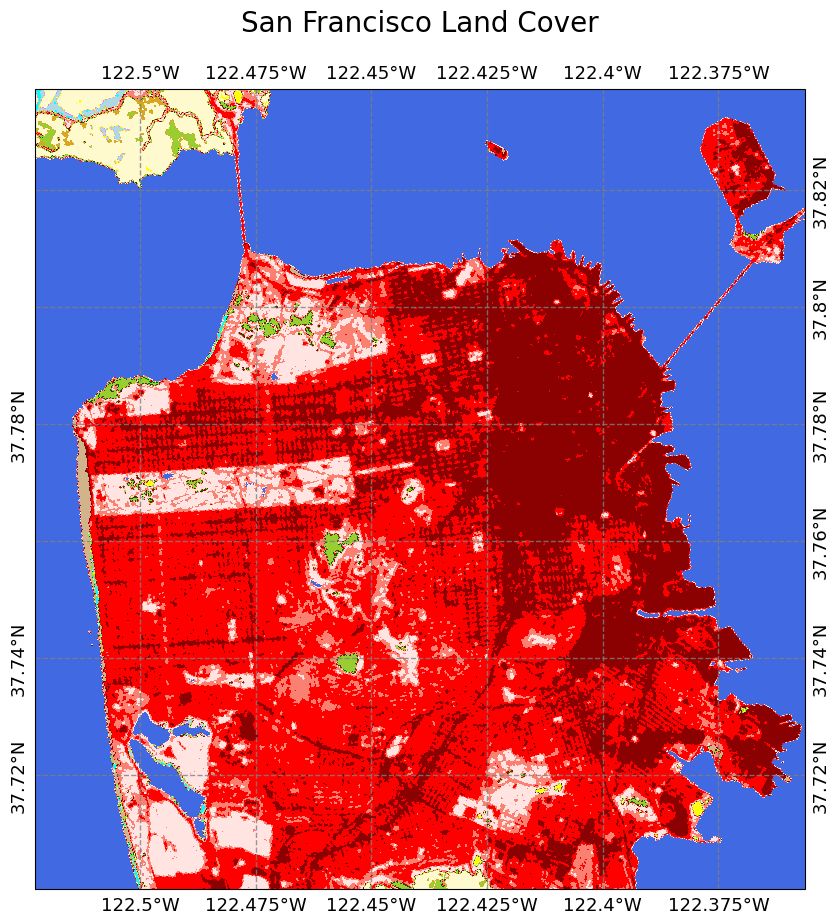

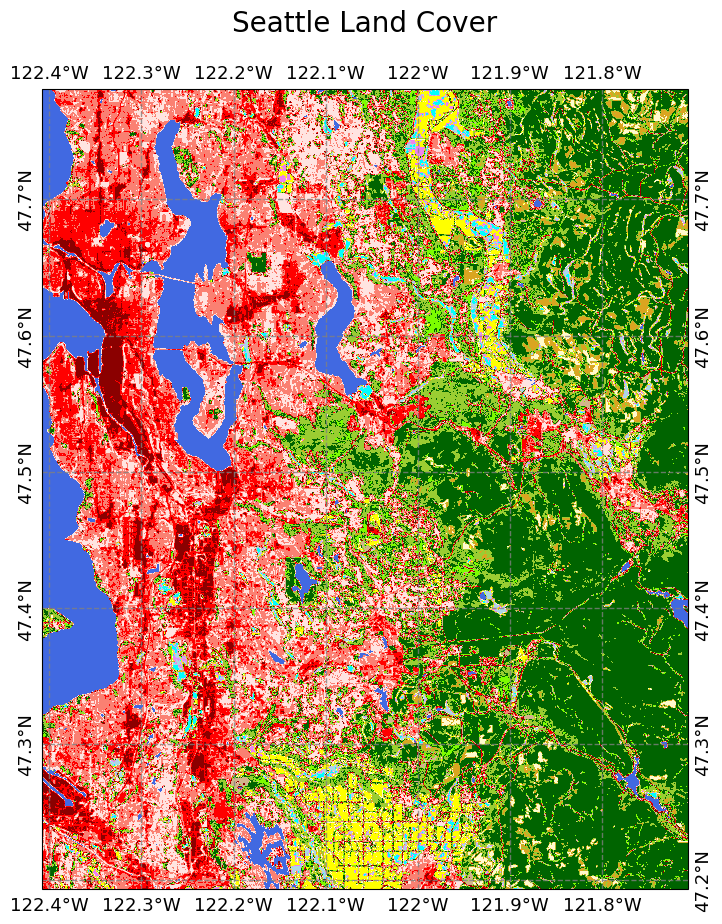

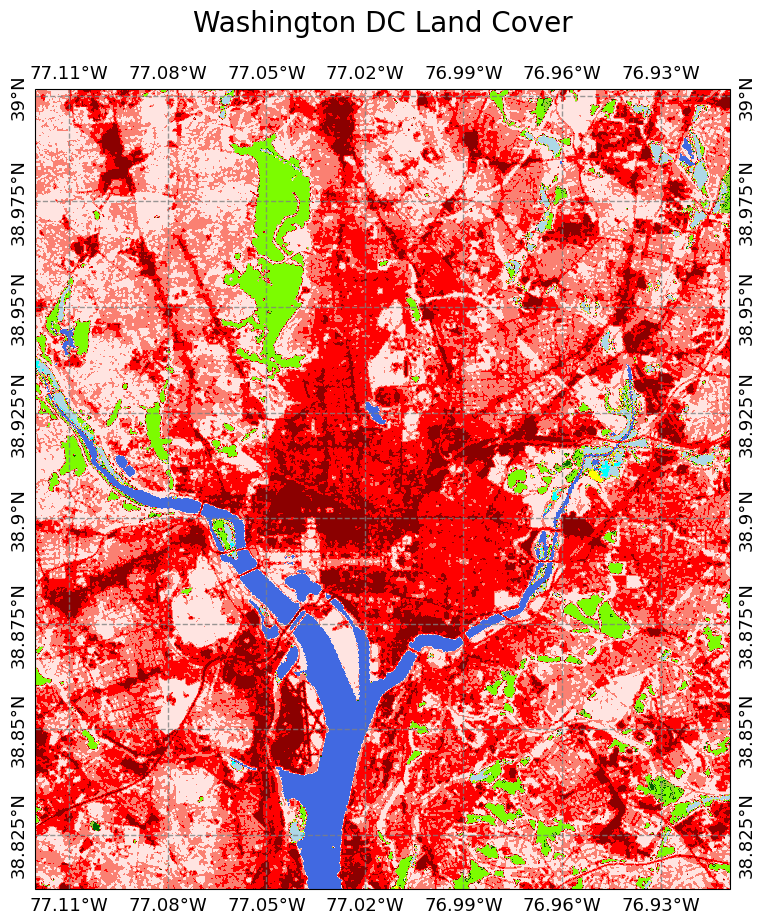

In [4]:
developed_land = {}
for city in cities:
    tif_nlcd = f'../data/land/{city}_nlcd.tif'
    with rio.open(tif_nlcd) as src:
        nlcd = src.read(1)
        bounds = src.bounds
    # Count the number of pixels in class 21-24
    developed_pixels = np.sum((nlcd >= 21) & (nlcd <= 24))
    # Calculate the total number of pixels in the image
    total_pixels = nlcd.size
    # Compute the percentage
    percentage = (developed_pixels / total_pixels) * 100
    developed_land[city] = percentage
    print(percentage)

    new_nlcd = nlcd.copy()
    for i, j in enumerate(np.unique(nlcd)):
        new_nlcd[nlcd==j] = i

    # Generate land cover colormap
    fig = plt.figure(figsize=(10,10))

    # Plot the raster data
    img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.8, linestyle='--', ylabel_style={'size': 13, 'rotation': 'vertical'}, xlabel_style={'size': 13})
    
    img = plt.imshow(new_nlcd, extent=img_extent, cmap=cmap)

    # Plot the points on top
    # cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.03])
    # cbar = plt.colorbar(img, cax=cbar_ax, orientation='horizontal', pad=0.05, shrink=0.8, )

    # tick_labels = np.unique(nlcd)
    # tick_positions = np.linspace(0.5,13.5,len(tick_labels))

    # cbar.set_ticks(tick_positions)
    # cbar.ax.set_xticklabels(tick_labels)
    # cbar.ax.tick_params(labelsize=11)

    fig.suptitle(f'{city} Land Cover', fontsize=20)


    plt.savefig(f'../figures/{city}_nlcd.png', dpi=300, bbox_inches='tight')
    # plt.show()

# Length Scale vs. Developed Land Percentage

In [5]:
developed_land

{'Albuquerque': np.float64(58.15179621456542),
 'Atlanta': np.float64(89.89629915485445),
 'Baltimore': np.float64(59.315466202207666),
 'Boston': np.float64(85.16783987820573),
 'Boulder': np.float64(56.01066611341946),
 'Chicago': np.float64(75.30927220789665),
 'Detroit': np.float64(76.00545346959011),
 'Durham': np.float64(58.90231869267375),
 'Houston': np.float64(77.40392984677824),
 'Kansas': np.float64(86.59301285103784),
 'Las Vegas': np.float64(47.93064733715258),
 'Los Angeles': np.float64(78.94053963830027),
 'Miami': np.float64(90.79737242664807),
 'Nashville': np.float64(78.23776224819103),
 'New Orleans': np.float64(54.88740807294267),
 'NYC': np.float64(83.35347492938729),
 'Oklahoma': np.float64(55.23528609803482),
 'San Francisco': np.float64(57.36013015062691),
 'Seattle': np.float64(43.30917454771237),
 'Washington DC': np.float64(89.32841217766928)}